In [1]:
import numpy as np
import os 
import sys
sys.path.append('../')
import src.learning as lrn
%load_ext autoreload
%matplotlib widget

## Transform

In [2]:
data_random = np.load("../saved/controllable_set/reachset_train/20231115-025054/data_random.npy")
data_structured = np.load("../saved/controllable_set/reachset_train/20231115-025054/data_structured.npy")

In [3]:
# print shapes
print(f"Random data shape: {data_random.shape}")
print(f"Structured data shape: {data_structured.shape}")

Random data shape: (68140, 11)
Structured data shape: (20585, 11)


In [5]:
# print bounds for each column
names = ["h", "vx", "vz", "m", "tgo", "x_xmax", "y_xmax", "x_xmin", "y_xmin", "x_ymax", "y_ymax"]
for data in [data_structured, data_random]:
    print("Structured" if data is data_structured else "Random")
    for i in range(data.shape[1]):
        print(f"{names[i]}: [{np.min(data[:, i])}, {np.max(data[:, i])}]")

Structured
h: [52.127631533784395, 1652.9776316311097]
vx: [0.3263441682622546, 55.94801083605122]
vz: [-96.25053158953001, 84.9887759056876]
m: [1545.9103079040513, 1903.2263149089836]
tgo: [9.600000000000001, 149.8]
x_xmax: [4.189482495655608, 217.61863491294304]
y_xmax: [0.0, 0.0]
x_xmin: [-217.61863366243162, 217.4539864829522]
y_xmin: [0.0, 0.0]
x_ymax: [-0.0003199288509331997, 217.4981489410149]
y_ymax: [0.1806506535426812, 217.61863366335717]
Random
h: [14.144100719893745, 1692.9266229047284]
vx: [7.484814183693819e-07, 56.01771011781459]
vz: [-99.95226381743866, 86.24251275796276]
m: [1552.935802705344, 1904.5681306871813]
tgo: [10.0, 150.0]
x_xmax: [1.862106186005685, 222.87801813764355]
y_xmax: [0.0, 0.0]
x_xmin: [-222.8026601225657, 216.4802465568183]
y_xmin: [0.0, 0.0]
x_ymax: [-0.000702263509064533, 217.5152083108791]
y_ymax: [0.9463121147208833, 222.8026601199757]


In [6]:
reachset = np.vstack((data_structured, data_random))
print(f"Reachset shape: {reachset.shape}")
for i in range(reachset.shape[1]):
        print(f"{names[i]}: [{np.min(reachset[:, i])}, {np.max(reachset[:, i])}]")

Reachset shape: (88725, 11)
h: [14.144100719893745, 1692.9266229047284]
vx: [7.484814183693819e-07, 56.01771011781459]
vz: [-99.95226381743866, 86.24251275796276]
m: [1545.9103079040513, 1904.5681306871813]
tgo: [9.600000000000001, 150.0]
x_xmax: [1.862106186005685, 222.87801813764355]
y_xmax: [0.0, 0.0]
x_xmin: [-222.8026601225657, 217.4539864829522]
y_xmin: [0.0, 0.0]
x_ymax: [-0.000702263509064533, 217.5152083108791]
y_ymax: [0.1806506535426812, 222.8026601199757]


In [7]:
xmin_, xmax_, ymax_, x_ymax_ = lrn.transform_reachsetparam(
    xmin=reachset[:, 5], 
    xmax=reachset[:, 7], 
    ymax=reachset[:, 10], 
    x_ymax=reachset[:, 9], 
    alt=reachset[:, 0],
    )


In [8]:
# print max and min for xmin_, xmax_, ymax_, x_ymax_
print(f"xmin_: [{np.min(xmin_)}, {np.max(xmin_)}]")
print(f"xmax_: [{np.min(xmax_)}, {np.max(xmax_)}]")
print(f"ymax_: [{np.min(ymax_)}, {np.max(ymax_)}]")
print(f"x_ymax_: [{np.min(x_ymax_)}, {np.max(x_ymax_)}]")

xmin_: [0.6485419355084174, 0.9761906026337618]
xmax_: [0.023809522621763092, 0.9761638703320559]
ymax_: [0.008300795624695264, 0.9523809542854282]
x_ymax_: [0.49999731455629615, 0.976172388755526]


In [9]:
alt_, vx_, vz_, z_, tgo_ = lrn.transform_ic(
    alt=reachset[:, 0],
    vx=reachset[:, 1],
    vz=reachset[:, 2],
    z=np.log(reachset[:, 3]),
    tgo=reachset[:, 4],
    )
# print max and min for alt_, vx_, vz_, z_, tgo_
print(f"alt_: [{np.min(alt_)}, {np.max(alt_)}]")
print(f"vx_: [{np.min(vx_)}, {np.max(vx_)}]")
print(f"vz_: [{np.min(vz_)}, {np.max(vz_)}]")
print(f"z_: [{np.min(z_)}, {np.max(z_)}]")
print(f"tgo_: [{np.min(tgo_)}, {np.max(tgo_)}]")

alt_: [0.0070720503599468725, 0.8464633114523642]
vx_: [7.48481418369382e-09, 0.5601771011781459]
vz_: [0.0002386809128066858, 0.9312125637898138]
z_: [0.11379411909371827, 0.9990380177004928]
tgo_: [0.04800000000000001, 0.75]


# Training

In [10]:
import torch
from torch.utils.data import DataLoader, random_split

In [11]:
# define hyperparameters
train_data_rate = 0.95
batch_size = 256

# create dataset and dataloader
dataset = lrn.ReachsetDataset(reachset=reachset)
n_data = len(dataset)
train_size = int(train_data_rate * n_data)
test_size = n_data - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-2
hidden_layers = [256, 256, 256]

mlp = lrn.NeuralReach(hidden_layers=hidden_layers)
mlp = mlp.to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

loss = torch.nn.MSELoss()

In [13]:
num_epochs = 50
print_every = 100
for epoch in range(num_epochs):
    for i, (_, x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y_hat = mlp(x)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        if (i + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {l.item():.4f}")

Epoch 1/50, Step 100/330, Loss: 0.0034
Epoch 1/50, Step 200/330, Loss: 0.0025
Epoch 1/50, Step 300/330, Loss: 0.0018
Epoch 2/50, Step 100/330, Loss: 0.0010
Epoch 2/50, Step 200/330, Loss: 0.0010
Epoch 2/50, Step 300/330, Loss: 0.0012
Epoch 3/50, Step 100/330, Loss: 0.0014
Epoch 3/50, Step 200/330, Loss: 0.0011
Epoch 3/50, Step 300/330, Loss: 0.0009
Epoch 4/50, Step 100/330, Loss: 0.0005
Epoch 4/50, Step 200/330, Loss: 0.0020
Epoch 4/50, Step 300/330, Loss: 0.0006
Epoch 5/50, Step 100/330, Loss: 0.0005
Epoch 5/50, Step 200/330, Loss: 0.0016
Epoch 5/50, Step 300/330, Loss: 0.0011
Epoch 6/50, Step 100/330, Loss: 0.0011
Epoch 6/50, Step 200/330, Loss: 0.0005
Epoch 6/50, Step 300/330, Loss: 0.0011
Epoch 7/50, Step 100/330, Loss: 0.0007
Epoch 7/50, Step 200/330, Loss: 0.0006
Epoch 7/50, Step 300/330, Loss: 0.0015
Epoch 8/50, Step 100/330, Loss: 0.0009
Epoch 8/50, Step 200/330, Loss: 0.0007
Epoch 8/50, Step 300/330, Loss: 0.0010
Epoch 9/50, Step 100/330, Loss: 0.0006
Epoch 9/50, Step 200/330,

In [14]:
# save model with timestamp
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y%m%d-%H%M%S")
out_dir = f"../saved/controllable_set/reachset_train/models_{now}"
os.makedirs(out_dir)
torch.save(mlp.state_dict(), f"{out_dir}/mlp.pth")

## Convex NN Training

In [15]:
import torch.nn as nn 
class ConvexNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        """
        Initialize the modified neural network.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        """
        super(ConvexNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers.append(output_dim)

        # Main layers from previous hidden layer
        self.main_layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            linear = nn.Linear(prev_dim, hidden_dim)
            if prev_dim != input_dim:  # Apply positivity constraint only to layers after the first
                with torch.no_grad():
                    linear.weight.clamp_(min=0)
            self.main_layers.append(linear)
            prev_dim = hidden_dim

        # Additional layers from the original input
        self.additional_layers = nn.ModuleList()
        for hidden_dim in hidden_layers[1:]:  # Skip first layer as it directly connects to input
            linear = nn.Linear(input_dim, hidden_dim)
            with torch.no_grad():
                linear.weight.clamp_(min=0)
            self.additional_layers.append(linear)

        # Output layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        for i, main_layer in enumerate(self.main_layers):
            x_main = main_layer(x if i == 0 else output)

            # Apply additional layer if not the first hidden layer
            if i > 0:
                x_additional = self.additional_layers[i-1](x)
                output = nn.ReLU()(x_main + x_additional)
            if i == len(self.main_layers) - 1:
                output = x_main
            else:
                output = nn.ReLU()(x_main)

        return output
    
    def clamp_weights(self):
        """
        Ensure that the weights remain positive after training updates, except for the first layer.
        """
        for i, layer in enumerate(self.main_layers):
            if i > 0 and isinstance(layer, nn.Linear):  # Skip the first layer
                with torch.no_grad():
                    layer.weight.clamp_(min=0)
            #if i < len(self.additional_layers) and isinstance(self.additional_layers[i], nn.Linear):
            #    with torch.no_grad():
            #        self.additional_layers[i].weight.clamp_(min=0)

# Example usage
modified_model = ConvexNN(input_dim=10, output_dim=5, hidden_layers=[20, 30])
print(modified_model)

ConvexNN(
  (main_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=5, bias=True)
  )
  (additional_layers): ModuleList(
    (0): Linear(in_features=10, out_features=30, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
  )
  (output_layer): Linear(in_features=5, out_features=5, bias=True)
)


In [16]:
class NeuralReachCvx(ConvexNN):
    def __init__(self, hidden_layers=[256, 256, 256]):
        input_dim = 5  # alt, vx, vz, z, tgo
        output_dim = 4  # xmin, xmax, ymax, x-ymax
        super(NeuralReachCvx, self).__init__(
            input_dim,
            output_dim,
            hidden_layers,
        )

    def forward(self, x):
        out = super(NeuralReachCvx, self).forward(x)
        # change sign of first (xmin) and third (ymax) output to ensure convexity
        out[:, [1, 2]] = -out[:, [1, 2]]
        return out

In [17]:
cvx_model = NeuralReachCvx(hidden_layers=hidden_layers).double()
cvx_model = cvx_model.to(device)

optimizer = torch.optim.Adam(cvx_model.parameters(), lr=lr)

loss = torch.nn.MSELoss()

In [18]:
num_epochs = 50
print_every = 100
for epoch in range(num_epochs):
    for i, (_, x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y_hat = cvx_model(x)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        cvx_model.clamp_weights()
        if (i + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {l.item():.4f}")

Epoch 1/50, Step 100/330, Loss: 0.2172
Epoch 1/50, Step 200/330, Loss: 0.0624
Epoch 1/50, Step 300/330, Loss: 0.0409
Epoch 2/50, Step 100/330, Loss: 0.0391
Epoch 2/50, Step 200/330, Loss: 0.0419
Epoch 2/50, Step 300/330, Loss: 0.0367
Epoch 3/50, Step 100/330, Loss: 0.0314
Epoch 3/50, Step 200/330, Loss: 0.0337
Epoch 3/50, Step 300/330, Loss: 0.0387
Epoch 4/50, Step 100/330, Loss: 0.0346
Epoch 4/50, Step 200/330, Loss: 0.0336
Epoch 4/50, Step 300/330, Loss: 0.0408
Epoch 5/50, Step 100/330, Loss: 0.0365
Epoch 5/50, Step 200/330, Loss: 0.0362
Epoch 5/50, Step 300/330, Loss: 0.0367
Epoch 6/50, Step 100/330, Loss: 0.0382
Epoch 6/50, Step 200/330, Loss: 0.0383
Epoch 6/50, Step 300/330, Loss: 0.0393
Epoch 7/50, Step 100/330, Loss: 0.0375
Epoch 7/50, Step 200/330, Loss: 0.0334
Epoch 7/50, Step 300/330, Loss: 0.0411
Epoch 8/50, Step 100/330, Loss: 0.0364
Epoch 8/50, Step 200/330, Loss: 0.0415
Epoch 8/50, Step 300/330, Loss: 0.0370
Epoch 9/50, Step 100/330, Loss: 0.0436
Epoch 9/50, Step 200/330,

In [21]:
torch.save(cvx_model.state_dict(), f"{out_dir}/cvx_model.pth")

# Validation with newly generated data; check smoothness and convexity

In [34]:
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import ConvexHull
from scipy.optimize import linprog
from tqdm import tqdm

from src.reachset import random_sampling_in_hull
from gen_reachset_train import solve

In [20]:
data = np.load('../saved/controllable_set/data.npy')
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)
N = 100

In [29]:
indices = [2, 3, 5, 6, 7]
data_5d = data[:, indices]
data_bounds = (np.min(data_5d, axis=0), np.max(data_5d, axis=0))
data_normalized = (data_5d - data_bounds[0]) / (data_bounds[1] - data_bounds[0])
hull_5d = ConvexHull(data_normalized, qhull_options='Q12')

In [22]:
samples = random_sampling_in_hull(hull_5d.equations, (np.zeros(5), np.ones(5)), 100)

c:\Users\ktomita3\Documents\001_workspace\learning-hda-reachability\dev\..\src\reachset\ic_sampler.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  if not (np.dot(eq[:-1], point) + eq[-1] <= 0):


In [51]:
def solve4bounds(hull, data_point):
    A_ub = hull.equations[:, :-1]
    b_ub = -hull.equations[:, -1]

    # solve for max and min for each dimension
    maxs = np.zeros(5)
    mins = np.zeros(5)
    for i in range(5):
        c = np.zeros(5)
        c[i] = 1
        A_eq = np.zeros((5, 5))
        b_eq = np.zeros(5)
        for j in range(5):
            if i == j:
                continue
            A_eq[j, j] = 1
            b_eq[j] = data_point[j]

        mins[i] = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun
        maxs[i] = -linprog(-c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq).fun

    return mins, maxs

def solve4reachset(param_idx, param_bounds, n, nominal_x, data_bounds):
    param_min, param_max = param_bounds
    ic_values = np.linspace(param_min, param_max, n)
    ic_list = []
    for i in range(n):
        ic = nominal_x.copy()
        ic[param_idx] = ic_values[i]
        ic = ic * (data_bounds[1] - data_bounds[0]) + data_bounds[0]
        ic[4] = np.round(ic[4], decimals=2)
        ic_list.append(ic)

    reach_data = solve(ic_list, lander, N)
    return np.array(reach_data)

def visualize(reach_data, param_idx, param_name, fig=None, axs=None, color='b'):
    if fig is None:
        fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    params = reach_data[:, param_idx]
    y_data_indices = [5, 7, 10, 9]
    y_labels = ['x-max', 'x-min', 'y-max', 'x-ymax']
    axs = axs.flatten()
    for i in range(4):
        axs[i].plot(params, reach_data[:, y_data_indices[i]], color=color)
        axs[i].set_xlabel(param_name)
        axs[i].set_ylabel(y_labels[i])
    plt.tight_layout()
    return fig, axs

In [24]:
n_sample = 3
data_points = samples[np.random.choice(samples.shape[0], n_sample, replace=False)]
center = np.mean(samples, axis=0)

In [30]:
# Sove for bounds
local_bounds = np.zeros((n_sample, 2, 5))
for i in range(n_sample):
    mins, maxs = solve4bounds(hull_5d, data_points[i])
    local_bounds[i, 0] = mins
    local_bounds[i, 1] = maxs

In [48]:
# Solve for reachset
n = 10
reach_data_dict = {}

param_indices = [0, 1, 2, 3, 4]
param_names = ['altitude', 'vx', 'vz', 'mass', 'tgo']
pbar = tqdm(total=len(param_indices) * n_sample)
for param_idx, param_name in zip(param_indices, param_names):
    reach_data_list = []
    for i, data_point in enumerate(data_points):
        local_bound = (local_bounds[i, 0, param_idx], local_bounds[i, 1, param_idx])
        reach_data = solve4reachset(param_idx, local_bound, n, data_point, data_bounds)
        reach_data_list.append(reach_data)
        pbar.update(1)

    reach_data_dict[param_name] = reach_data_list

  0%|          | 0/15 [00:16<?, ?it/s]


In [123]:
reach_data_dict_nn = {}
pbar = tqdm(total=len(param_indices) * n_sample)
for param_idx, param_name in zip(param_indices, param_names):
    reach_data_nn_list = []
    for i, reach_data in enumerate(reach_data_dict[param_name]):
        reach_data_nn = np.copy(reach_data)
        ic_batch = reach_data[:, :5]
        alt, vx, vz, m, tgo = ic_batch[:, 0], ic_batch[:, 1], ic_batch[:, 2], ic_batch[:, 3], ic_batch[:, 4]
        alt_, vx_, vz_, z_, tgo_ = lrn.transform_ic(alt=alt, vx=vx, vz=vz, z=np.log(m), tgo=tgo)
        x_batch = np.vstack((alt_, vx_, vz_, z_, tgo_)).T
        x_batch = torch.tensor(x_batch, dtype=torch.float64).to(device)
        y_batch = mlp(x_batch).cpu().detach().numpy()
        xmin_, xmax_, ymax_, x_ymax_ = y_batch[:, 0], y_batch[:, 1], y_batch[:, 2], y_batch[:, 3]
        xmin, xmax, ymax, x_ymax = lrn.inverse_transform_reachsetparam(xmin_, xmax_, ymax_, x_ymax_, alt)
        reach_data_nn[:, 5] = xmax
        reach_data_nn[:, 7] = xmin
        reach_data_nn[:, 10] = ymax
        reach_data_nn[:, 9] = x_ymax
        reach_data_nn_list.append(reach_data_nn)

        pbar.update(1)

    reach_data_dict_nn[param_name] = reach_data_nn_list


100%|██████████| 15/15 [03:25<00:00, 13.69s/it]


In [132]:
reach_data_dict_nn_cvx = {}
pbar = tqdm(total=len(param_indices) * n_sample)
for param_idx, param_name in zip(param_indices, param_names):
    reach_data_nn_list = []
    for i, reach_data in enumerate(reach_data_dict[param_name]):
        reach_data_nn = np.copy(reach_data)
        ic_batch = reach_data[:, :5]
        alt, vx, vz, m, tgo = ic_batch[:, 0], ic_batch[:, 1], ic_batch[:, 2], ic_batch[:, 3], ic_batch[:, 4]
        alt_, vx_, vz_, z_, tgo_ = lrn.transform_ic(alt=alt, vx=vx, vz=vz, z=np.log(m), tgo=tgo)
        x_batch = np.vstack((alt_, vx_, vz_, z_, tgo_)).T
        x_batch = torch.tensor(x_batch, dtype=torch.float64).to(device)
        y_batch = cvx_model(x_batch).cpu().detach().numpy()
        xmin_, xmax_, ymax_, x_ymax_ = y_batch[:, 0], y_batch[:, 1], y_batch[:, 2], y_batch[:, 3]
        xmin, xmax, ymax, x_ymax = lrn.inverse_transform_reachsetparam(xmin_, xmax_, ymax_, x_ymax_, alt)
        reach_data_nn[:, 5] = xmax
        reach_data_nn[:, 7] = xmin
        reach_data_nn[:, 10] = ymax
        reach_data_nn[:, 9] = x_ymax
        reach_data_nn_list.append(reach_data_nn)

        pbar.update(1)

    reach_data_dict_nn_cvx[param_name] = reach_data_nn_list

100%|██████████| 15/15 [09:01<00:00, 36.08s/it]


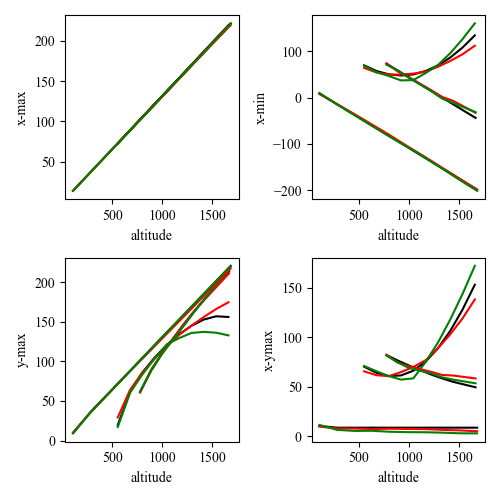

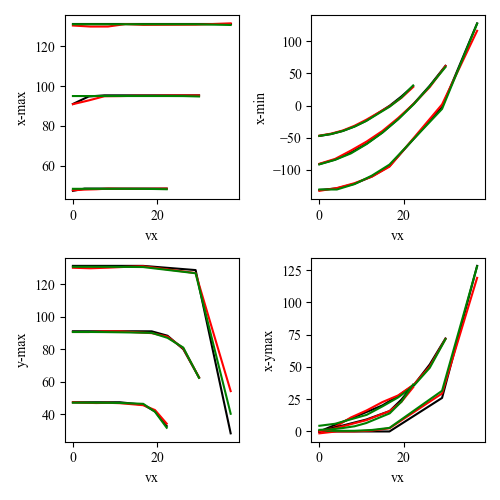

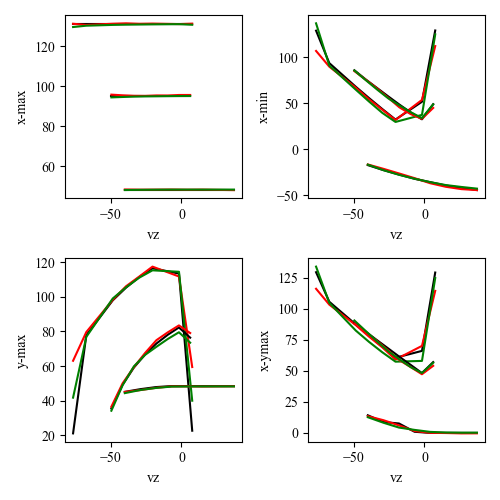

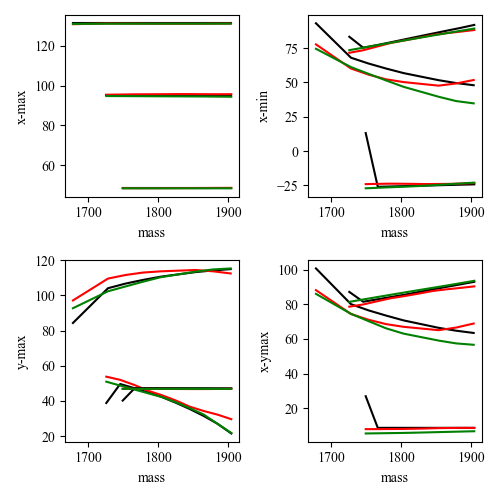

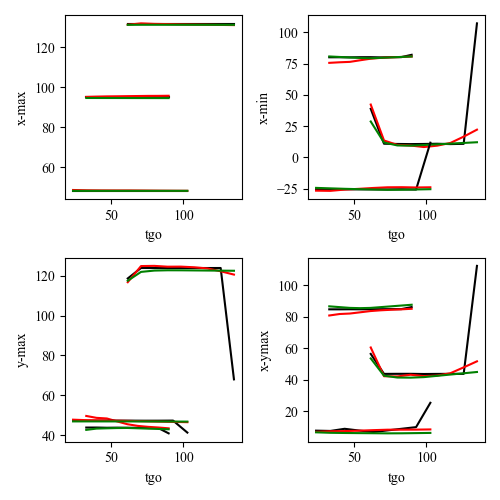

In [133]:
for param_idx, param_name in zip(param_indices, param_names):
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    for i in range(n_sample):
        visualize(reach_data_dict[param_name][i], param_idx, param_name, fig, axs, color='k')
        visualize(reach_data_dict_nn[param_name][i], param_idx, param_name, fig, axs, color='r')
        visualize(reach_data_dict_nn_cvx[param_name][i], param_idx, param_name, fig, axs, color='g')
    plt.tight_layout()
    plt.show()

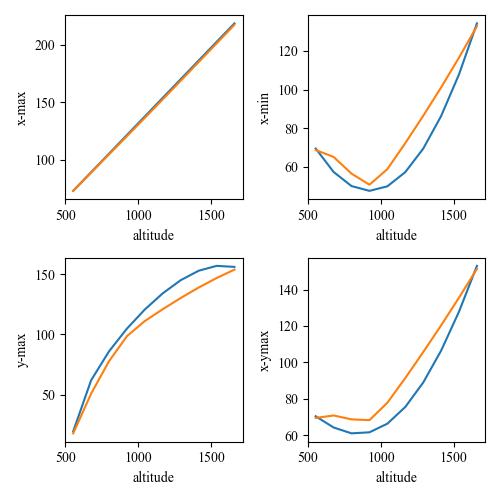

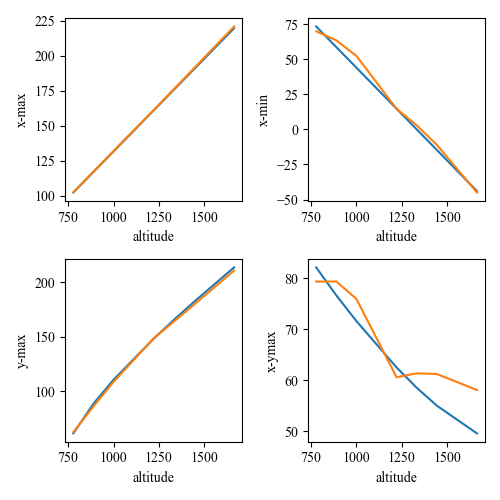

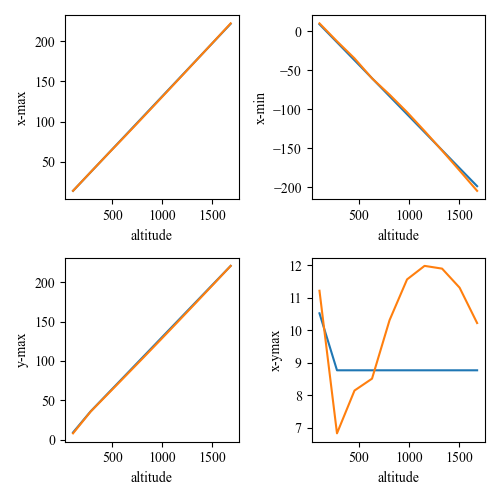

In [46]:
for i in range(n_sample):
    fig, axs = visualize(reach_data_dict[param_name][i], param_idx, param_name)
    fig, axs = visualize(reach_data_dict_nn[param_name][i], param_idx, param_name, fig=fig, axs=axs)
    plt.show()

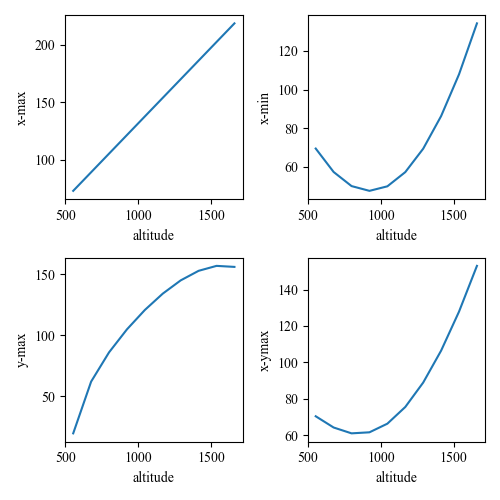

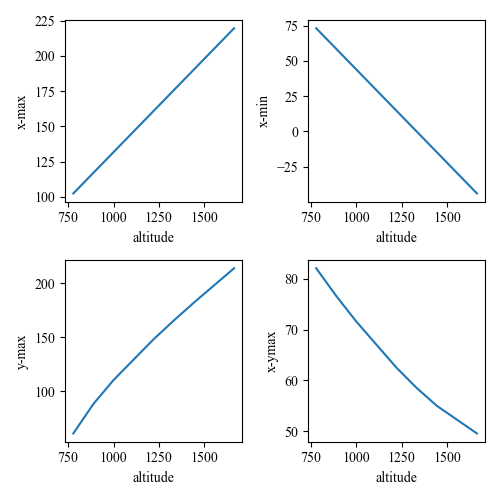

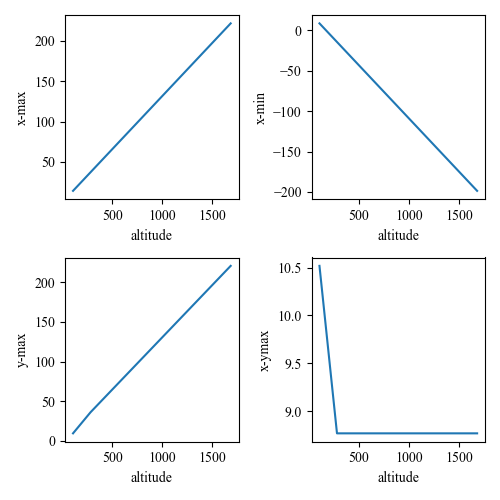

In [25]:
n = 10
param_idx = 0
param_name = 'altitude'

for data_point in data_points:
    mins, maxs = solve4bounds(hull_5d, data_point)
    reach_data = solve4reachset(param_name, param_idx, (mins[param_idx], maxs[param_idx]), n, data_point, data_bounds)
    fig, axs = visualize(reach_data, param_idx, param_name)
    plt.show()